In [1]:
!pip -q install tensorflow-io python-Levenshtein

# OCR
This is just the training notebook. Will create an inference notebook later. Data generated from [this](https://www.kaggle.com/aditya08/ocr-create-word-level-data) notebook.

Extracting text of various sizes, shapes, and orientations from images is an essential problem in many contexts. To tackle this problem, one needs to accurately extract the text from images.

Basically, text extraction can be achieved into two steps, i.e., text detection and text recognition or by training a single model to achieve both text detection and recognition

**Text detection** helps identify the region in the image where the text is present. It takes in an image as an input, and the outputs bounding boxes.

**Text recognition** extracts the text from the input image using the bounding boxes obtained from the text detection model. It takes in an image and some bounding boxes as inputs and outputs some raw text.


> Here, since the text of interest are already focused upon, we need not worry about text detection & only need to solve the problem of text recognition

## Versions
**Version 1** - Training on image dimensions (250, 600)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from collections import OrderedDict
import os
from glob import glob
from itertools import chain
import random
from tqdm.notebook import tqdm
import time

import cv2
import Levenshtein
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Bidirectional, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Lambda, Layer, LSTM, MaxPooling2D, Reshape
from tensorflow.keras.models import Model
import tensorflow_io as tfio

In [4]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
sns.set_style("darkgrid")

## Constants

In [5]:
SEED = 42
IMG_HEIGHT = 250
IMG_WIDTH = 600
EPOCHS = 8
BATCH_SIZE = 16

## Utility Functions

In [6]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [7]:
seed_everything(SEED)

In [8]:
def plot_hist(hist):
    plt.figure(figsize=(6, 6))
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

In [9]:
def plot_grid(dataset, h=4, w=4, title=""):
    f, ax = plt.subplots(h, w, figsize=(30, 30))
    for batch in dataset.shuffle(100).take(1):
        images = batch["image"]
        labels = batch["label"]
        for i in range(h*w):
            img = (images[i] * 255).numpy().astype("uint8")
            label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
            ax[i // h, i % w].imshow(img[:, :, 0].T, cmap="gray")
            ax[i // h, i % w].axis("off")
            ax[i // h, i % w].set_title(label, fontdict={"fontsize": 20})
    plt.tight_layout()
    plt.suptitle(title, fontsize="large", fontweight="extra bold")
    plt.show()

## Loading Data

In [10]:
!ls ../input/ocr-crnn-train-word-split-250-600/images/images | wc

  48018   48018  469070


In [11]:
train_df = pd.read_csv("../input/ocr-crnn-train-word-split-250-600/train.csv")[["Path", "Labels"]]
train_df["Path"] = train_df["Path"].apply(lambda x: f"../input/ocr-crnn-train-word-split-250-600/images/{x}")
train_df = train_df.dropna()
train_df.shape

(44795, 2)

In [12]:
train_df.head()

,Path,Labels
0,../input/ocr-crnn-train-word-split-250-600/ima...,ADULTEROUS
1,../input/ocr-crnn-train-word-split-250-600/ima...,"WIFE,"
2,../input/ocr-crnn-train-word-split-250-600/ima...,"EH,"
3,../input/ocr-crnn-train-word-split-250-600/ima...,"ORSINI?"""
4,../input/ocr-crnn-train-word-split-250-600/ima...,THIS


In [13]:
train_df["Labels"].str.len().value_counts(sort=False)

1     1984
2     7521
3     9390
4     7202
5     5274
6     3860
7     3365
8     2419
9     1682
10    1019
11     570
12     297
13     140
14      43
15      18
16       7
18       3
20       1
Name: Labels, dtype: int64

In [14]:
train_df["Labels"].str.len().quantile(q=np.arange(0.90, 1.0, 0.01))

0.90     8.0
0.91     8.0
0.92     9.0
0.93     9.0
0.94     9.0
0.95     9.0
0.96    10.0
0.97    10.0
0.98    11.0
0.99    12.0
Name: Labels, dtype: float64

***As 90th percentile for Label length is at 8, will drop columns where label length is greater than 8***

In [15]:
train_df = train_df.loc[train_df["Labels"].str.len()<=8]

In [16]:
train_df.shape

(41015, 2)

In [17]:
train_files = train_df["Path"].tolist()
train_labels = train_df["Labels"].tolist()

In [18]:
max_length = max([len(label) for label in train_labels])
print(f"Max Length: {max_length}")

Max Length: 8


***Padding*** labels to account for different text length

## Preprocessing

In [19]:
characters = [']', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', 
              '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 
              'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
              'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 
              '[', '!']
print("Number of unique characters: ", len(characters))

Number of unique characters:  54


In [20]:
# Mapping characters to integers
char_to_num = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), invert=True, mask_token=None
)

In [21]:
unk_token = "[UNK]"
mask_token = "]"

## Train-Valid Split

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df["Path"], train_df["Labels"], 
                                                      stratify=train_df["Labels"].str.len(), test_size=0.1)

In [23]:
print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_valid.shape}, {y_valid.shape}")

Training: (36913,), (36913,)
Validation: (4102,), (4102,)


## Create *TensorFlow DataSet* Objects

In [24]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .padded_batch(BATCH_SIZE) # pads to the smallest per-batch size that fits all elements
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

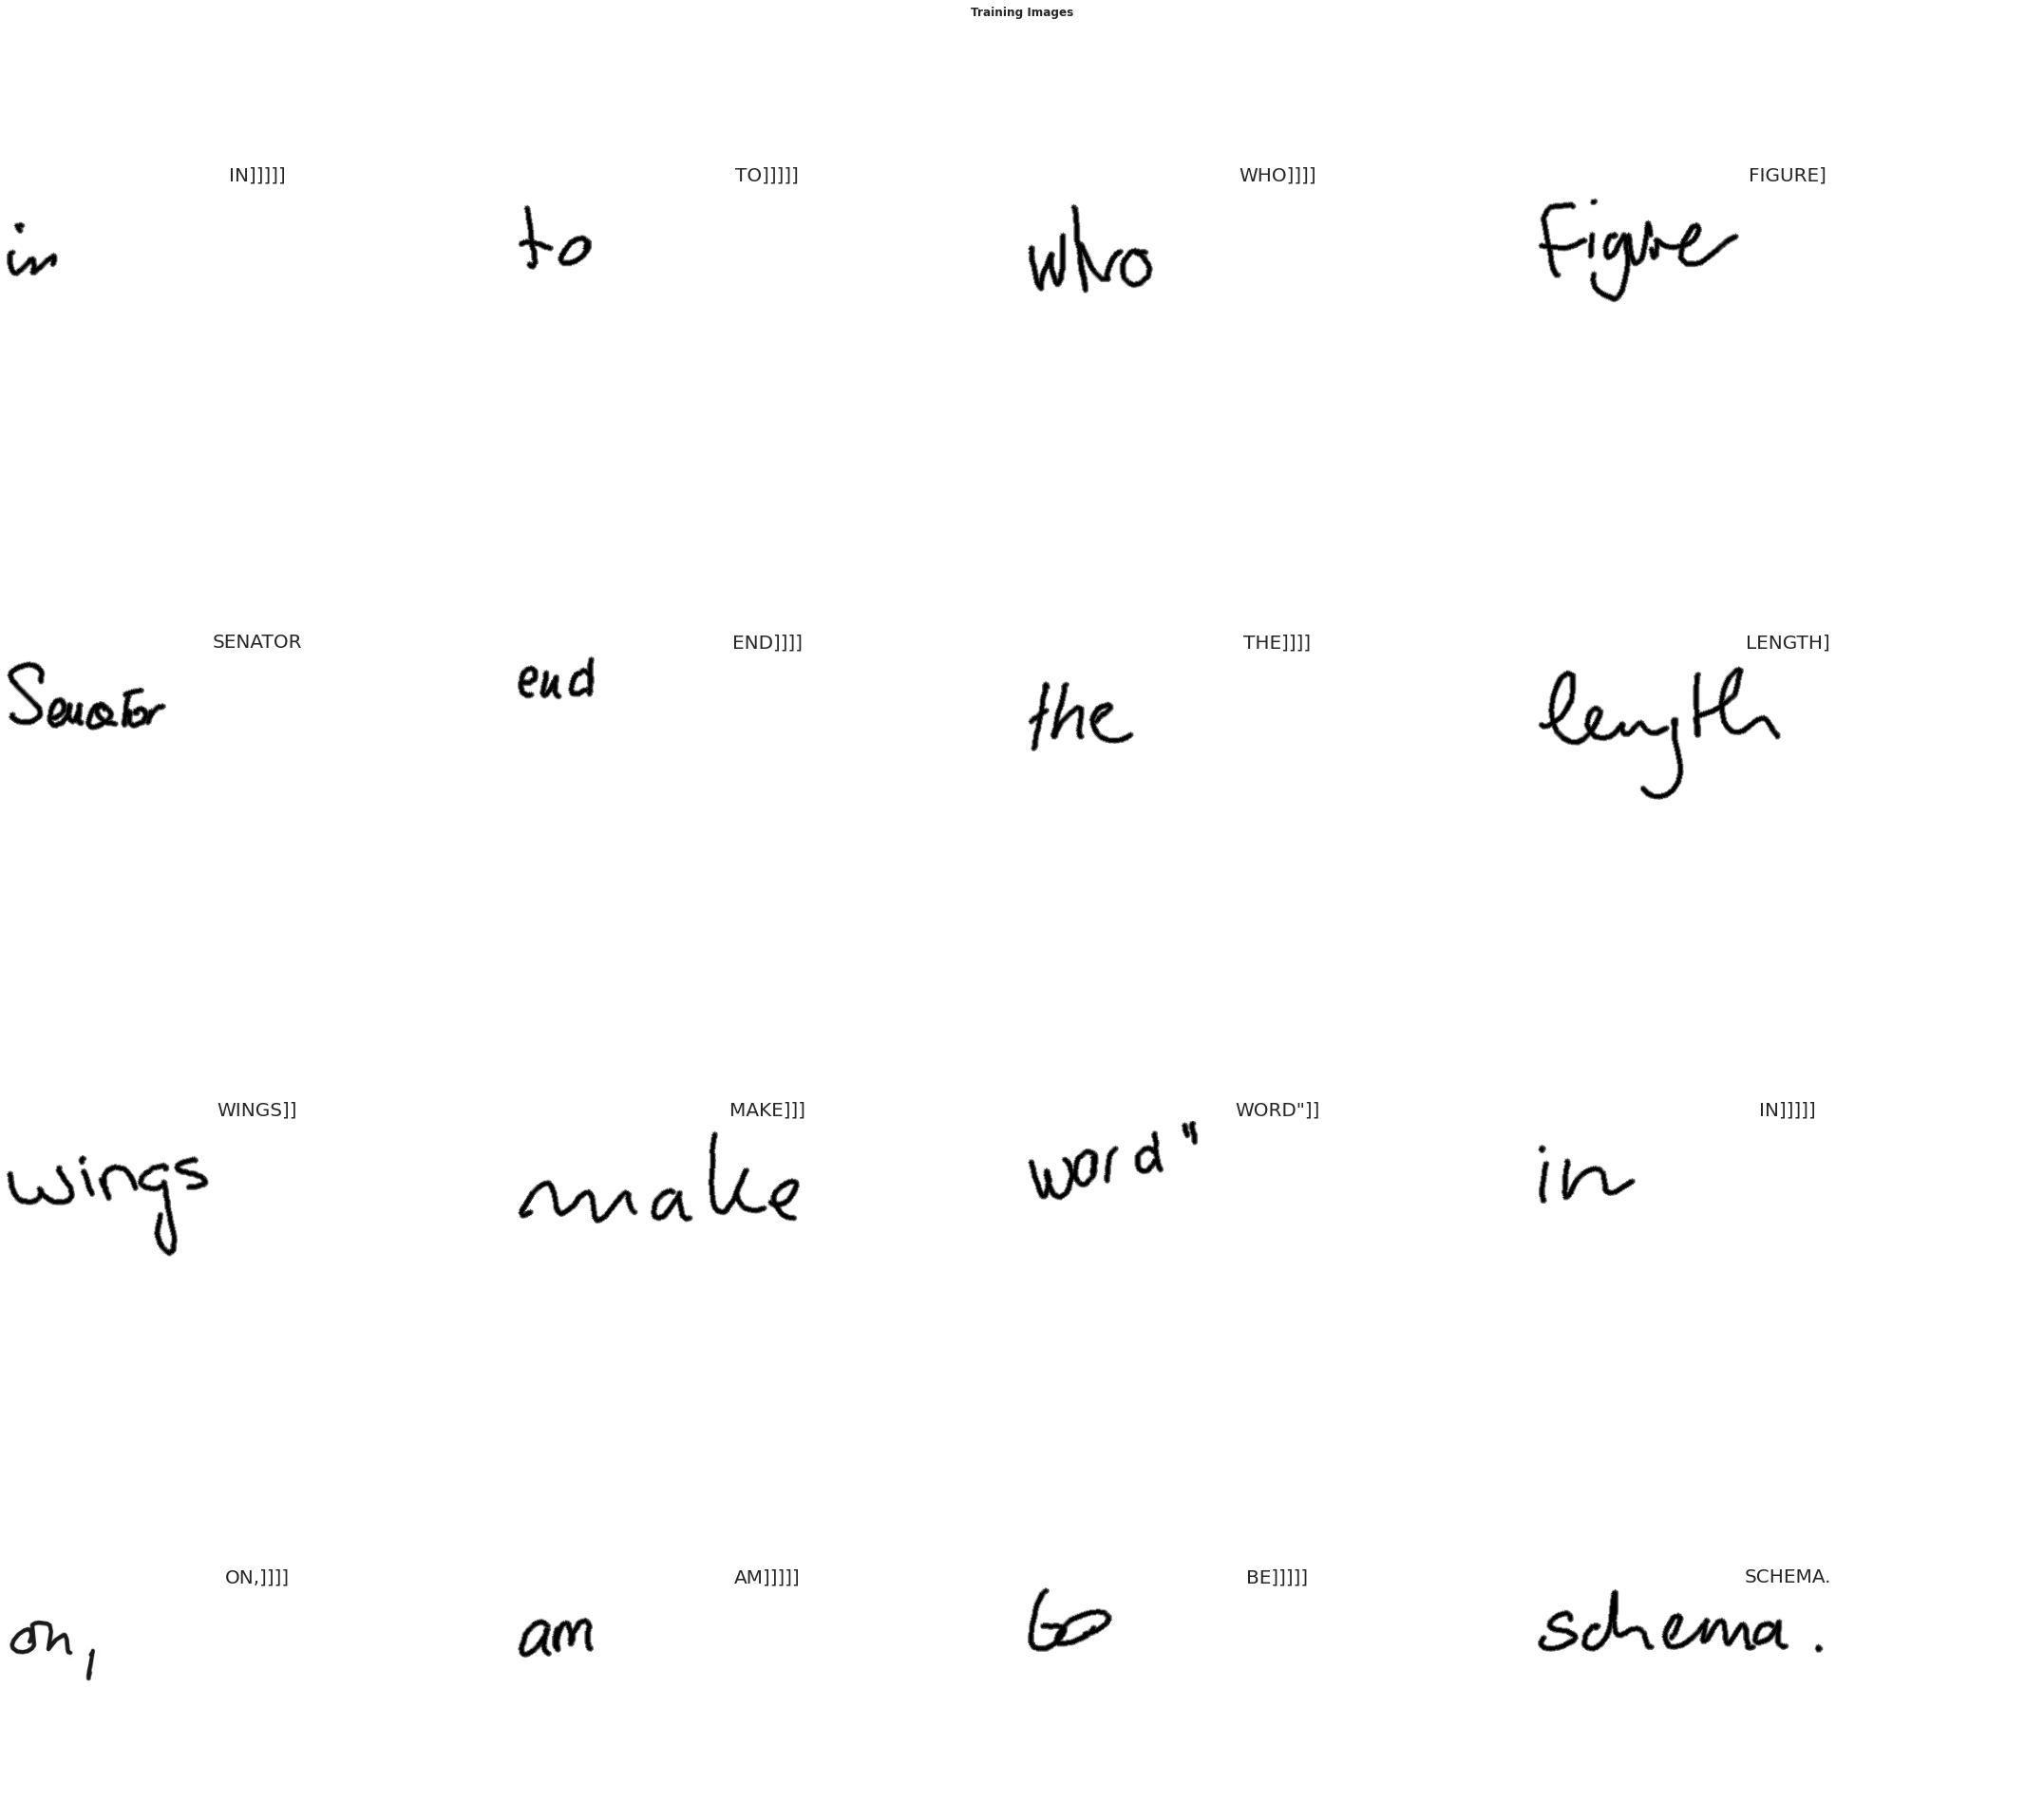

In [26]:
plot_grid(train_dataset, title="Training Images")

In [27]:
validation_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

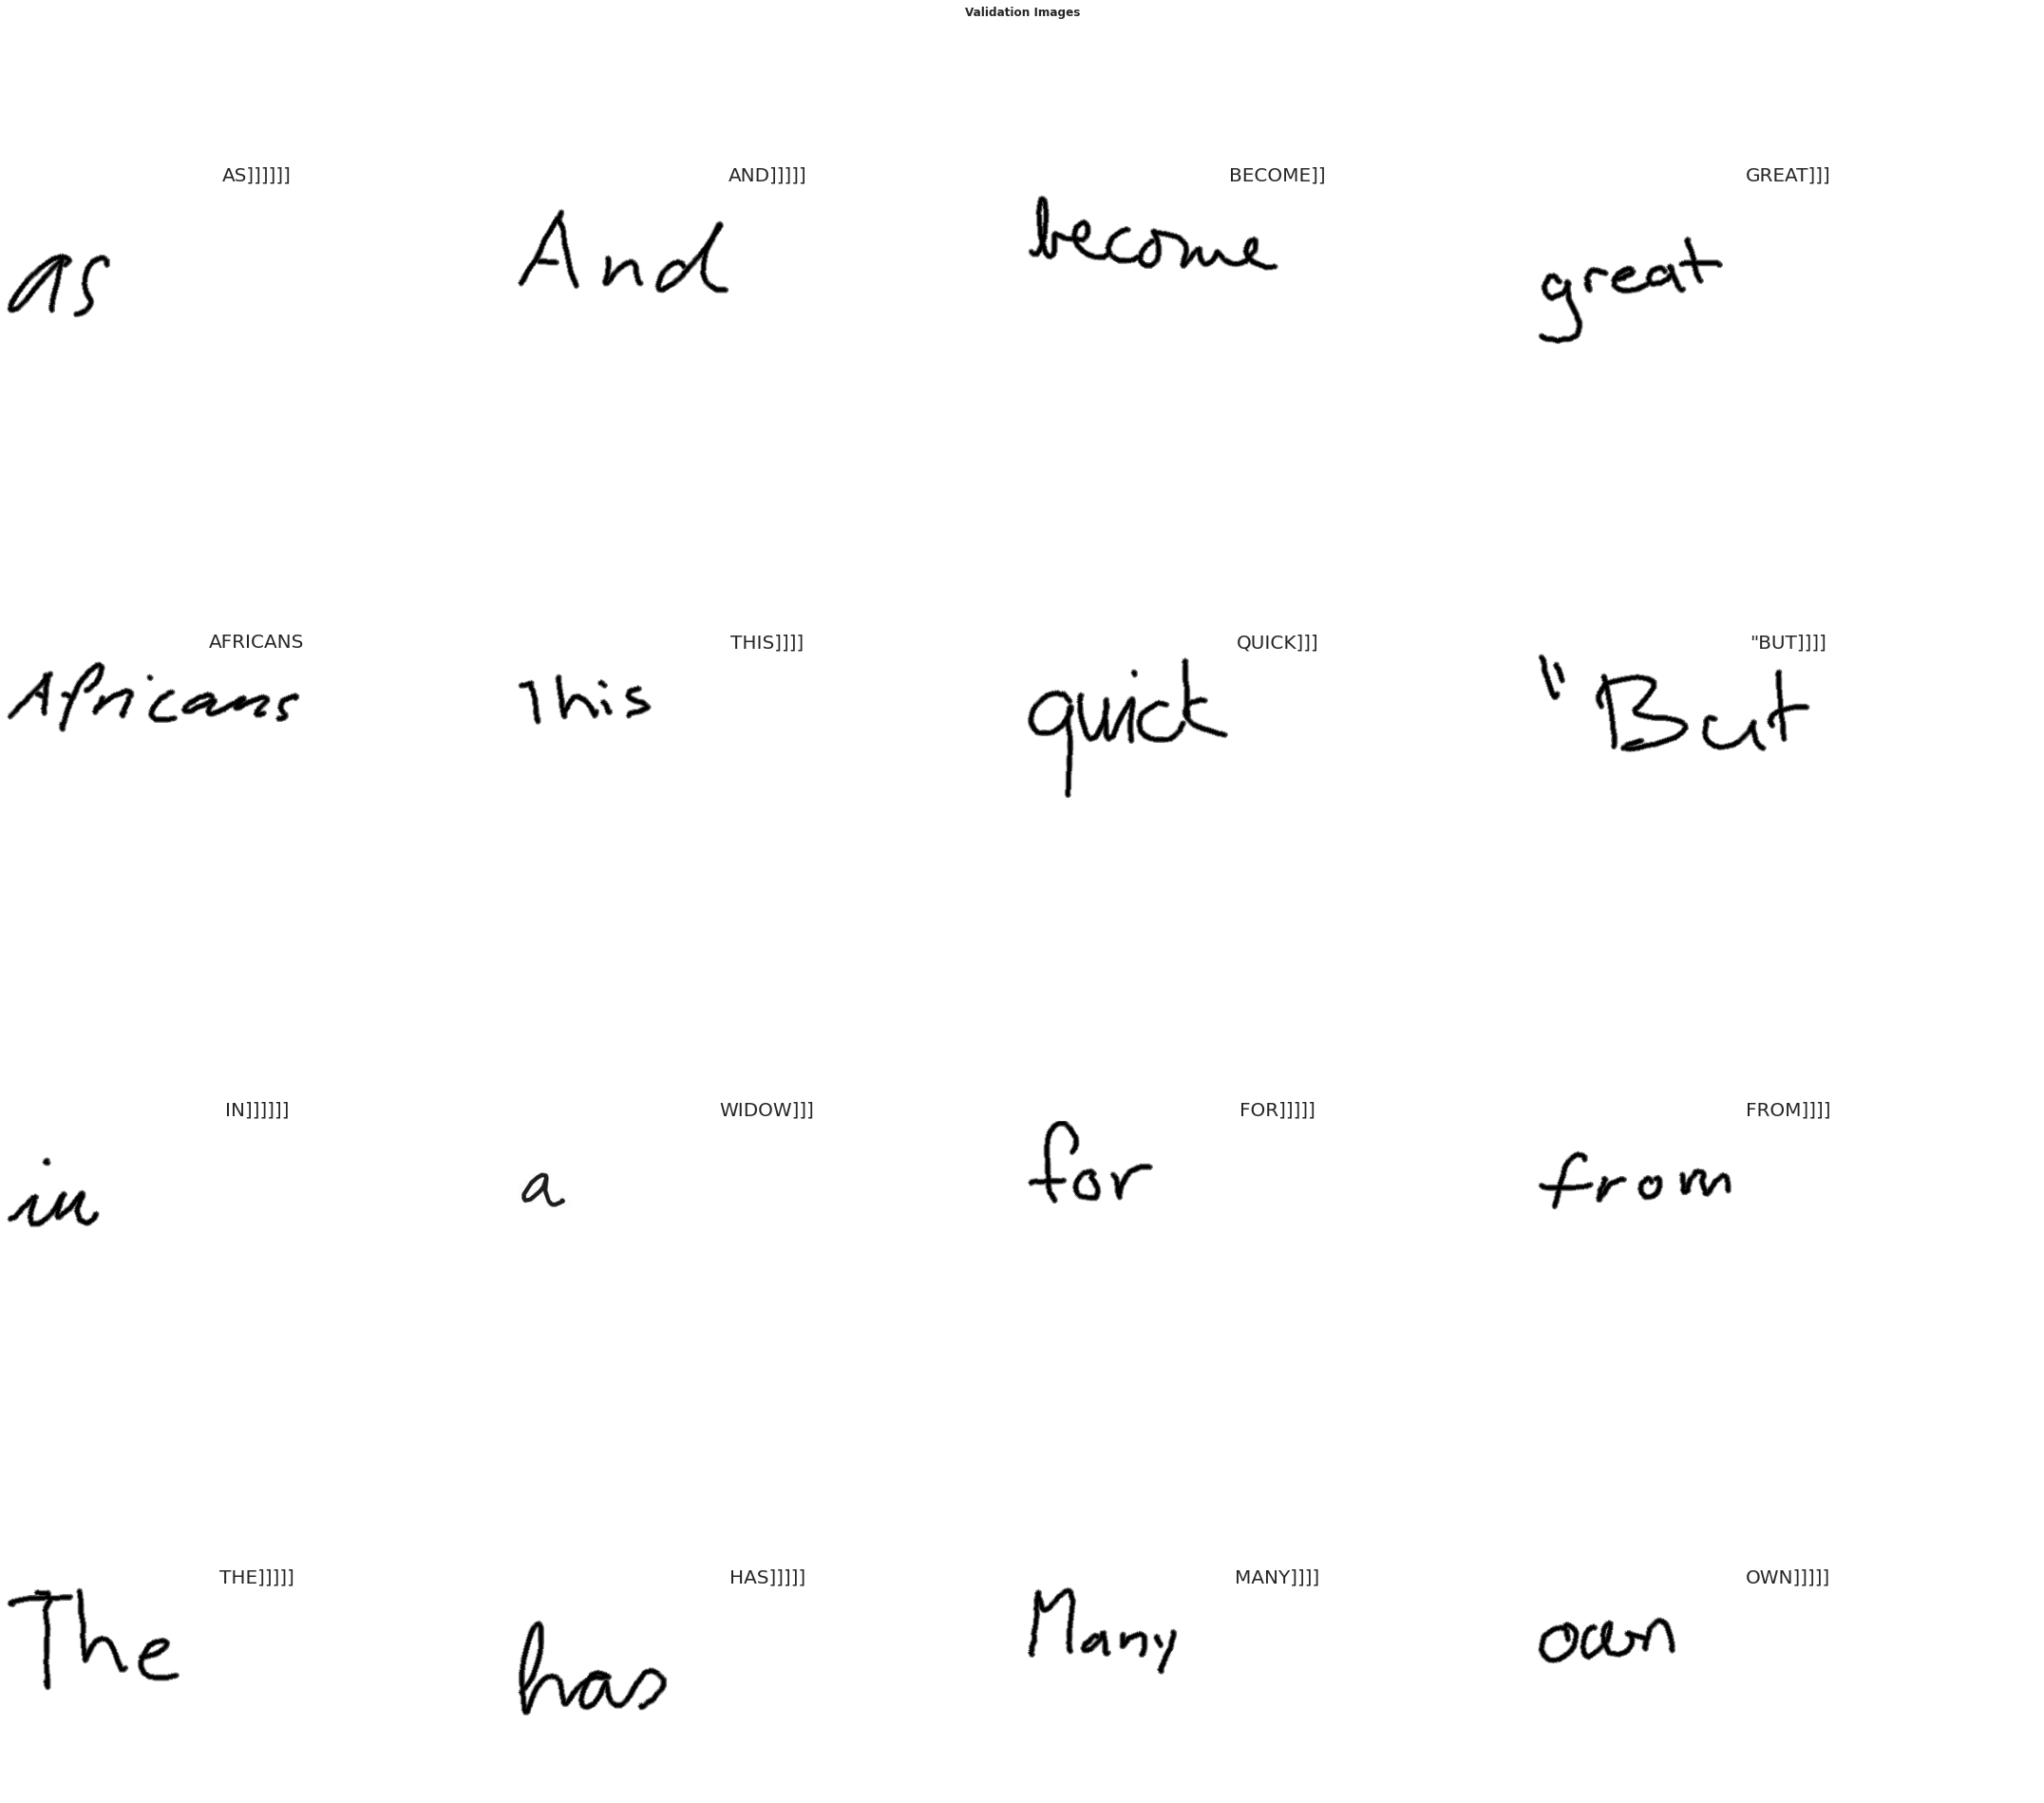

In [28]:
plot_grid(validation_dataset, title="Validation Images")

## Convolutional Recurrent Neural Network (CRNN)

In [29]:
class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [30]:
def build_crnn_model():
    # Inputs to the model
    input_img = Input(
        shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32"
    )
    labels = Input(name="label", shape=(None,), dtype="float32")

    """
    Why is the need for 7 conv layers?
    """
    # First conv block
    x = Conv2D(16, (3, 3), activation="relu", padding="same", name="conv_1")(input_img)
    x = Conv2D(32, (3, 3), activation="relu", padding="same", name="conv_2")(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same", name="conv_3")(x)
    x = BatchNormalization(name="bn_1")(x)
    x = MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = Conv2D(64, (3, 3), activation="relu", padding="same", name="conv_4")(x)
    x = Conv2D(128, (3, 3), activation="relu", padding="same", name="conv_5")(x)
    x = BatchNormalization(name="bn_2")(x)
    x = MaxPooling2D((2, 2), name="pool2")(x)

    # Third conv block
    x = Conv2D(128, (3, 3), activation="relu", padding="same", name="conv_6")(x)
    x = Conv2D(128, (3, 3), activation="relu", padding="same", name="conv_7")(x)
    x = BatchNormalization(name="bn_3")(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((IMG_WIDTH // 4), (IMG_HEIGHT // 4) * 128)
    x = Reshape(target_shape=new_shape, name="reshape")(x)
    x = Dense(64, activation="relu", name="dense1")(x)
    x = Dropout(0.2)(x)

    # RNNs
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(x)
    x = Bidirectional(LSTM(32, return_sequences=True, dropout=0.2))(x)

    # Output layer
    x = Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = tf.keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

## Training

In [31]:
model = build_crnn_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 600, 250, 1) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 600, 250, 16) 160         image[0][0]                      
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 600, 250, 32) 4640        conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 600, 250, 64) 18496       conv_2[0][0]                     
_______________________________________________________________________________________

In [32]:
early_stopping_patience = 4
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

checkpoint_filepath = "model_checkpoints/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="val_loss",
    mode="min",
    save_best_only=True)

In [33]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint_callback],
)

Epoch 1/8
2308/2308 [==============================] - 3476s 1s/step - loss: 29.1721 - val_loss: 35.9357
Epoch 2/8
2308/2308 [==============================] - 3444s 1s/step - loss: 13.6507 - val_loss: 33.9669
Epoch 3/8
2308/2308 [==============================] - 3445s 1s/step - loss: 12.4915 - val_loss: 11.4456
Epoch 4/8
2308/2308 [==============================] - 3446s 1s/step - loss: 10.9049 - val_loss: 10.7559
Epoch 5/8
2308/2308 [==============================] - 3448s 1s/step - loss: 9.0546 - val_loss: 22.7788
Epoch 6/8
2308/2308 [==============================] - 3448s 1s/step - loss: 7.6223 - val_loss: 48.9512
Epoch 7/8
2308/2308 [==============================] - 3448s 1s/step - loss: 6.8286 - val_loss: 25.1042
Epoch 8/8
2308/2308 [==============================] - 3447s 1s/step - loss: 6.3605 - val_loss: 30.8584


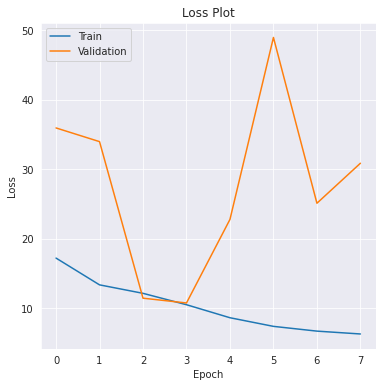

In [34]:
plot_hist(history)

In [35]:
model.save("crnn_model.h5")
model.save_weights("crnn_model_weights.h5")

## Inference

In [36]:
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 600, 250, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 600, 250, 16)      160       
_________________________________________________________________
conv_2 (Conv2D)              (None, 600, 250, 32)      4640      
_________________________________________________________________
conv_3 (Conv2D)              (None, 600, 250, 64)      18496     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 600, 250, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 300, 125, 64)      0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 300, 125, 64)      36928 

In [37]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [38]:
def get_all_preds(dataset):
    """
    Utility function that returns both model prediction & actual labels
    """
    decoded_text, actuals_text = [], []
    for batch in tqdm(dataset):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)
        # handling UNK & MASK token
        pred_texts = [x.replace(unk_token, '').replace(mask_token, '') for x in pred_texts]

        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label.replace(unk_token, '').replace(mask_token, ''))

        decoded_text.append(pred_texts)
        actuals_text.append(orig_texts)

    # flatten 2D list
    decoded_text = list(chain.from_iterable(decoded_text))
    actuals_text = list(chain.from_iterable(actuals_text))
    return decoded_text, actuals_text

In [39]:
prediction_model.save("prediction_model.h5")

Save the entire model as a *SavedModel*

In [40]:
!mkdir -p saved_model
prediction_model.save('saved_model/prediction_model')

### Validation Data Evaluation

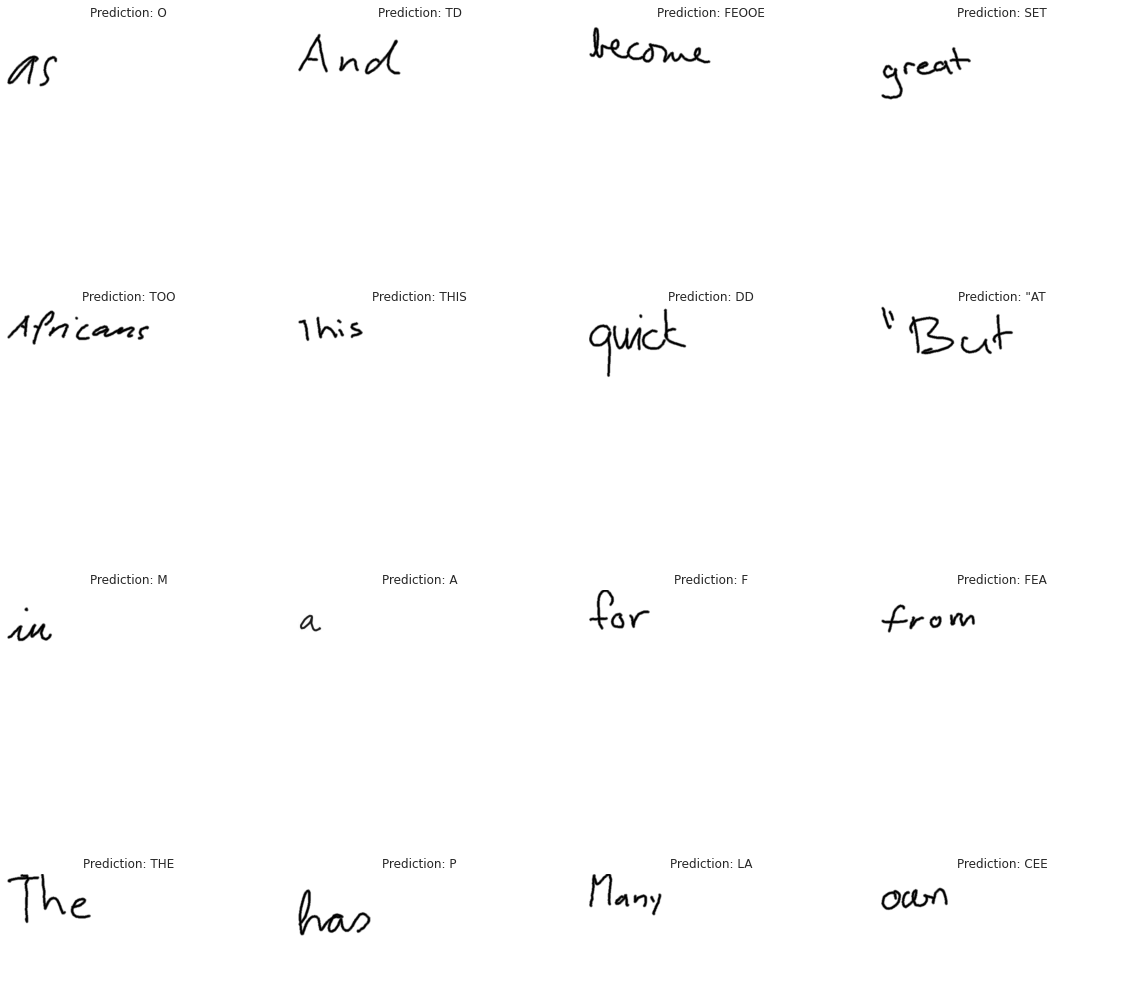

In [41]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(20, 20))
    for i in range(16):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        # handling UNK & MASK tokens
        title = f"Prediction: {pred_texts[i].replace(unk_token, '').replace(mask_token, '')}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [42]:
start_time = time.time()
decoded_text, actuals_text = get_all_preds(validation_dataset)
total_time = time.time() - start_time
print(f"Ran in {total_time:.3f} s")

  0%|          | 0/257 [00:00<?, ?it/s]

Ran in 329.397 s


In [43]:
actuals_text[:5], decoded_text[:5]

(['AS', 'AND', 'BECOME', 'GREAT', 'AFRICANS'],
 ['O', 'TD', 'FEOOE', 'SET', 'TOO'])

### Accuracy

In [44]:
print(f"Validation Data Accuracy: {accuracy_score(actuals_text, decoded_text):.5f}")

Validation Data Accuracy: 0.07655


### Levenhstien Distance

In [45]:
def get_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        score = Levenshtein.distance(true, pred)
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score

In [46]:
print(f"Validation Data Mean Levenshtein Distance: {get_score(actuals_text, decoded_text):.5f}")

Validation Data Mean Levenshtein Distance: 2.68064


## Training Data Evaluation

In [47]:
start_time = time.time()
decoded_text, actuals_text = get_all_preds(train_dataset)
total_time = time.time() - start_time
print(f"Ran in {total_time:.3f} s")

  0%|          | 0/2308 [00:00<?, ?it/s]

Ran in 2965.598 s


In [48]:
print(f"Training Data Accuracy: {accuracy_score(actuals_text, decoded_text):.5f}")

Training Data Accuracy: 0.07236


In [49]:
print(f"Training Data Mean Levenshtein Distance: {get_score(actuals_text, decoded_text):.5f}")

Training Data Mean Levenshtein Distance: 2.67166


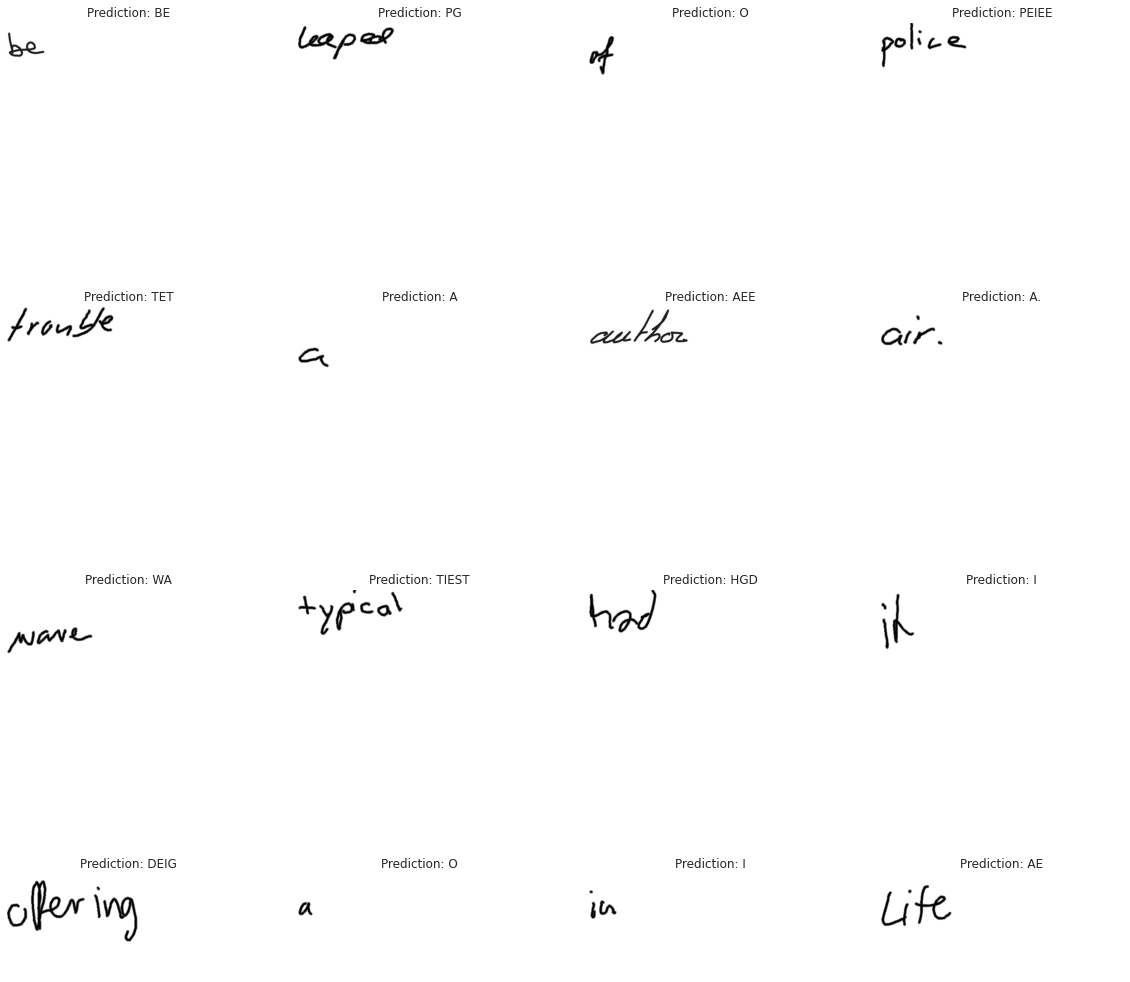

In [50]:
#  Let's check results on some validation samples
for batch in train_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(20, 20))
    for i in range(16):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        # handling UNK & MASK tokens
        title = f"Prediction: {pred_texts[i].replace(unk_token, '').replace(mask_token, '')}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [51]:
!rm -rf images